![image.png](https://i.imgur.com/a3uAqnb.png)

# 👁️👁️ **PyTorch CNN from Scratch: Fashion-MNIST**

**In this notebook إن شاء الله you will learn how to:**
1. Build a dataset class for Fashion-MNIST
2. Build a small CNN model class
3. Training & Evaluation
4. Evaluate results through a confusion matrix


## Very Quick Recap:

| **Operation** | **Function** | **Purpose** | **Example Transformation** |
|--------------|-------------|-------------|----------------------------|
| **Flatten** | `.flatten()` | Convert tensor to (batch, features) | `(32, 3, 28, 28) → (32, 3*28*28)` |
| **Squeeze** | `.squeeze()` | Remove dims of size 1 | `(1, 3, 28, 28) → (3, 28, 28)` |
| **Unsqueeze** | `.unsqueeze(dim)` | Add a dim of size 1 | `(3, 28, 28) → (1, 3, 28, 28)` |
| **Permute** | `.permute(dims)` | Change order of dimensions | `(32, 28, 28, 3) → (32, 3, 28, 28)` |
| **View** | `.view(shape)` | Reshape freely | `(32, 28, 28, 3) → (32, 28*28*3)` |

## Configurations

In [1]:
from IPython.display import clear_output
!pip install torch torchvision matplotlib scikit-learn
clear_output()

In [18]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # it is better to run CNNs with GPUs for faster computation
device

device(type='cpu')

## 1️⃣ **Dataset Class**

### 1.1 Transform functions
A transform is a set of operations applied to each image when it’s loaded

**Why?** → It is useful to:

*   Convert input data to tensors
*   Normalize data for model stabilization
*   Augmentate training data for model robustness

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),   # light augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


### 1.2 Custom Class
A Python class that implements:
*   `__len__()` (how many samples)
*   `__getitem__(i)` (how to return the i-th sample)

**Why?** → Lets you have greater control over your dataset

In [5]:
class FashionMNISTCustom(Dataset):

    def __init__(self, root, train: bool, transform=None, download: bool = True):
        super().__init__()
        self.base = datasets.FashionMNIST(root=root, train=train, download=download)
        self.transform = transform

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, label = self.base[idx]  # img is a PIL image
        if self.transform is not None:
            img = self.transform(img)
        return {"image": img, "label": int(label), "index": int(idx)}


### 1.3 Define datasets

In [6]:
train_ds = FashionMNISTCustom(root="./data", train=True,  download=True, transform=transform_train)
test_ds  = FashionMNISTCustom(root="./data", train=False, download=True, transform=transform_test)

# We got the label information from the Fashion-MNIST dataset page on Kaggle
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print("\nTrain size:", len(train_ds), "| Test size:", len(test_ds))


100%|██████████| 26.4M/26.4M [00:01<00:00, 21.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 341kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.27MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.6MB/s]


Train size: 60000 | Test size: 10000


### 1.4 Quick visualization
Plotting a few sample images and labels from the dataset to ensure that the data was loaded correctly

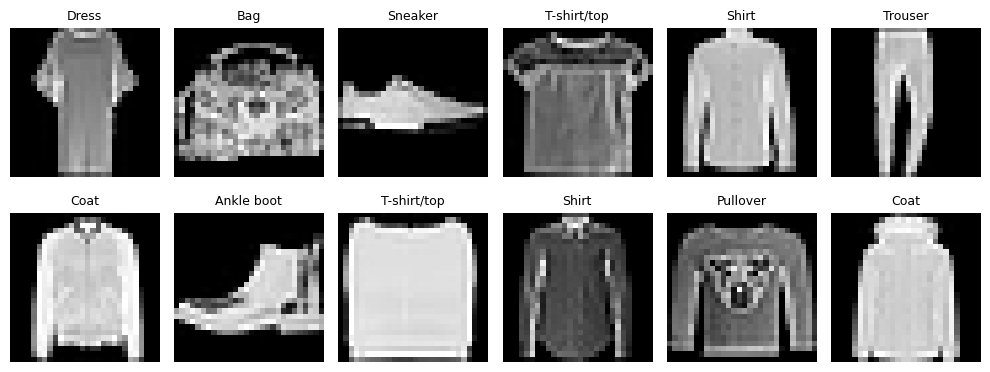

In [7]:
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
for ax in axes.ravel():
    idx = np.random.randint(0, len(train_ds))
    sample = train_ds[idx]
    x, y = sample["image"], sample["label"]

    # unnormalize for display (approx)
    x_vis = (x * 0.5) + 0.5
    ax.imshow(x_vis.squeeze(0), cmap="gray")
    ax.set_title(class_names[y], fontsize=9)
    ax.axis("off")
plt.tight_layout()
plt.show()


### 1.5 DataLoaders
A DataLoader wraps the dataset and creates batches of data handling batching, shuffling, parallel loading, and more

**Why?** → Neural networks train efficiently on batches, not one image at a time.

In [8]:
batch_size = 128 # design choice: you could change this to 16, 32, 64...

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


In [9]:
batch = next(iter(train_loader))
xb = batch["image"]
yb = batch["label"]
print("Train loader batch sample X shape (input):", tuple(xb.shape), "\Train loader batch sample y shape (target):", tuple(yb.shape))


Train loader batch sample X shape (input): (128, 1, 28, 28) \Train loader batch sample y shape (target): (128,)


<>:4: SyntaxWarning: invalid escape sequence '\T'
<>:4: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-2566728616.py:4: SyntaxWarning: invalid escape sequence '\T'
  print("Train loader batch sample X shape (input):", tuple(xb.shape), "\Train loader batch sample y shape (target):", tuple(yb.shape))
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


## 2️⃣ **Model Class**
Encapsulates the model architecture cleanly as a subclass of nn.Module that defines:

layers in `__init__`

forward computation in `forward()`



![image.png](https://i.imgur.com/8XKBFBU.jpeg)

In [10]:
class SimpleFashionCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(

            # TRACE THE SHAPE OF THE TENSORS AS IT PASSES THROUGH THE CONV LAYERS TO AVOID SHAPE MISMATCH ERRORS
            # HOW? --> by using the output features formula shown above

            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # [B,32,28,28]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B,32,14,14]

            # TO-DO: Add second Conv2d layer (input: 32, output: 64, kernel: 3, padding: 1)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [B,64,14,14]
            nn.ReLU(),
            # TO-DO: Add MaxPool2d with kernel_size=2
            nn.MaxPool2d(2),                            # [B,64,7,7]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # TO-DO: Calculate input features (channels × height × width)
            # After 2 MaxPool2d(2): 28 → 14 → 7
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # TO-DO: Pass x through features
        x = self.features(x)
        # TO-DO: Pass result through classifier
        x = self.classifier(x)
        return x


In [11]:
model = SimpleFashionCNN().to(device)

model # let's have a look at our model architecture

SimpleFashionCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

## 3️⃣ **Training & Evaluation**
Code that repeatedly:

1.   passes inputs through the model (forward pass)
2.   computes loss
3.   computes gradients (backward pass)
4.   updates weights (optimizer step)
5.   evaluates on validation/test without updating weights

**Training loop** is how the model learns, while the **validation loop** tells you how it performs on unseen data.

### 3.1 Training function

In [12]:
def accuracy_from_logits(logits, labels):
    # TO-DO: Get predicted class indices
    # HINT: Use torch.argmax with dim=1
    preds = torch.argmax(logits, dim=1)
    # TO-DO: Calculate and return accuracy
    # HINT: Compare preds with labels, convert to float, mean, then .item()
    return (preds == labels).float().mean().item()

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    for batch in tqdm(loader):
        images, labels = batch['image'], batch['label']
        images, labels = images.to(device), labels.to(device)

        # TO-DO: Zero the gradients
        optimizer.zero_grad()
        
        logits = model(images)
        loss = criterion(logits, labels)
        
        # TO-DO: Backward pass
        loss.backward()
        
        # TO-DO: Update parameters
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy_from_logits(logits.detach(), labels)

    return total_loss / len(loader), total_acc / len(loader)


### 3.2 Validation function

In [13]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_acc = 0.0, 0.0

    with torch.no_grad():
        for batch in tqdm(loader):
            images, labels = batch['image'], batch['label']
            images, labels = images.to(device), labels.to(device)

            # TO-DO: Get model predictions
            logits = model(images)
            
            # TO-DO: Calculate loss
            # HINT: Use the criterion function
            loss = criterion(logits, labels)

            total_loss += loss.item()
            total_acc += accuracy_from_logits(logits, labels)

    return total_loss / len(loader), total_acc / len(loader)


### 3.3 Setting hyperparameters + training the model

In [ ]:
# Training setup
# TO-DO: Define loss criterion
# HINT: What loss function works for multi-class classification?
criterion = nn.CrossEntropyLoss()

# TO-DO: Set learning rate
learning_rate = 0.001  # Typical range: 0.0001 to 0.01

# TO-DO: Define optimizer
# HINT: Pass model.parameters() and learning_rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# TO-DO: Set number of epochs
num_epochs = 10  # How many times to iterate through the dataset?

# Initialize history tracking
history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    
    # Store history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


100%|██████████| 79/79 [00:07<00:00, 10.17it/s]


Epoch 1/10 - Train Loss: 0.3302, Train Acc: 0.8798, Test Loss: 0.3026, Test Acc: 0.8883


100%|██████████| 79/79 [00:06<00:00, 11.35it/s]


Epoch 2/10 - Train Loss: 0.2868, Train Acc: 0.8952, Test Loss: 0.2845, Test Acc: 0.8953


 67%|██████▋   | 316/469 [00:58<00:25,  6.00it/s]

### 3.4 Plotting accuracy and loss curves
Graphs of training vs test loss/accuracy across epochs.

**Why?** → Helps diagnose problems of overfitting/underfitting, making training behavior visible instead of guessing.

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), history["train_loss"], label="train_loss", marker='o')
plt.plot(range(1, num_epochs+1), history["test_loss"], label="test_loss", marker='o')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), history["train_acc"], label="train_acc", marker='o')
plt.plot(range(1, num_epochs+1), history["test_acc"], label="test_acc", marker='o')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

plt.show()


## 4️⃣ **Evaluation**

### 4.1 Plot confusion matrix

A table showing counts of:

* true class (rows)
* predicted class (columns)

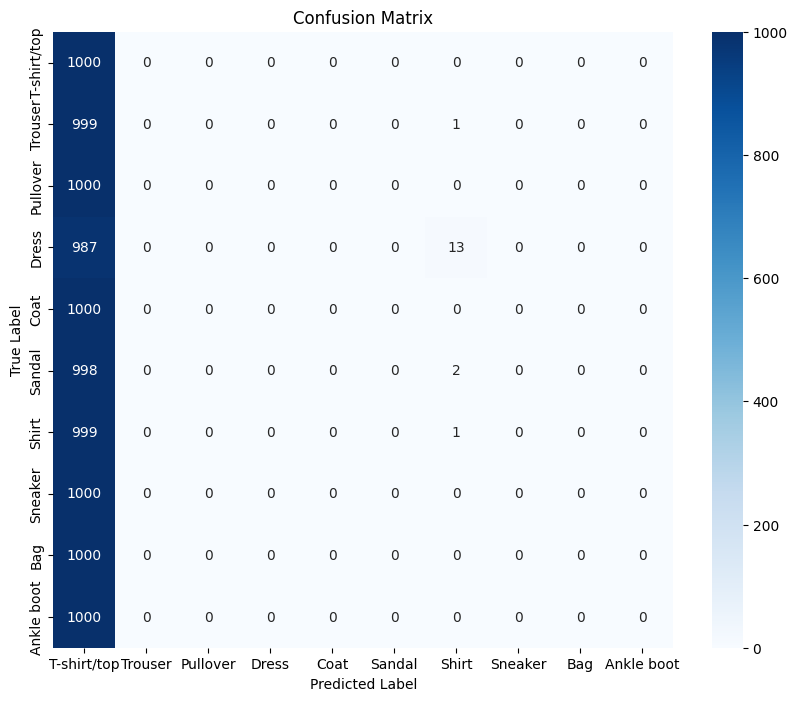

In [15]:
def collect_preds(model, loader):
    """Collect all predictions and true labels for confusion matrix"""
    all_preds = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in loader:
            images, labels = batch['image'], batch['label']
            images = images.to(device)
            
            # TO-DO: Get model predictions
            logits = model(images)
            
            # TO-DO: Convert logits to predicted classes
            # HINT: Use argmax to get class indices
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Collect predictions
preds, labels = collect_preds(model, test_loader)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


### 4.2 View ground truth and model prediction samples

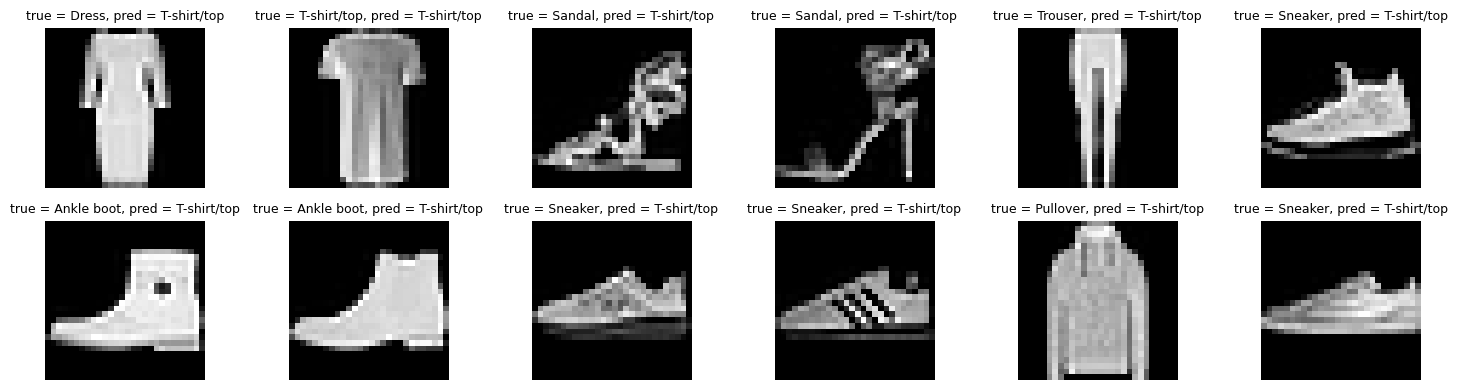

In [16]:
@torch.no_grad()
def show_predictions(model, dataset, n=12):
    model.eval()
    fig, axes = plt.subplots(2, n//2, figsize=(15, 4))
    axes = axes.ravel()

    for i in range(n):
        sample = dataset[np.random.randint(0, len(dataset))]
        x, y = sample['image'], sample['label']
        logits = model(x.unsqueeze(0).to(device))
        pred = torch.argmax(logits, dim=1).item()

        x_vis = (x * 0.5) + 0.5
        axes[i].imshow(x_vis.squeeze(0), cmap="gray")
        axes[i].set_title(f"true = {class_names[y]}, pred = {class_names[pred]}", fontsize=9)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

show_predictions(model, test_ds, n=12)


## 5️⃣ **Your turn**: optimize this pipeline through performing the following

- add `BatchNorm2d` after conv layers
- try a slightly deeper CNN (more channels)
- add `RandomRotation(10)` augmentation
- tune LR + epochs


![its ez](https://tenor.com/view/easy-staples-that-was-easy-staples-easy-button-easy-button-gif-21815485.gif)

### Contributed by: Farah Alshiha

![image.png](https://i.imgur.com/a3uAqnb.png)